2017 Domain Crawl Analysis
==============

See other notebooks for details.

In [11]:
# You need GEOS to get this to work:
# apt-get install libgeos-dev libgeos++-dev

import os

os.environ['http_proxy'] = 'http://explorer.bl.uk:3127'
os.environ['https_proxy'] = 'http://explorer.bl.uk:3127'

!pip install git+https://github.com/ukwa/python-webhdfs.git
!pip install geoip2
!pip install matplotlib
!pip install geos
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz


  Cloning https://github.com/ukwa/python-webhdfs.git to /tmp/pip-AivGBi-build
    100% |████████████████████████████████| 132.4MB 1.9kB/s eta 0:00:01B/s eta 0:00:09█████▌                         | 26.9MB 33.1MB/s eta 0:00:04��█████                        | 33.2MB 26.9MB/s eta 0:00:04MB/s eta 0:00:05██▎                    | 46.6MB 31.0MB/s eta 0:00:03██████████▎                  | 54.8MB 12.1MB/s eta 0:00:07/s eta 0:00:03eta 0:00:05�▎               | 67.3MB 17.8MB/s eta 0:00:04�               | 69.4MB 23.5MB/s eta 0:00:03            | 70.2MB 40.7MB/s eta 0:00:02 | 72.3MB 25.5MB/s eta 0:00:03�███████████▊              | 73.4MB 19.9MB/s eta 0:00:03MB/s eta 0:00:05██████▏           | 83.4MB 24.6MB/s eta 0:00:02:00:03▊          | 90.0MB 35.1MB/s eta 0:00:02███████████████          | 91.2MB 17.4MB/s eta 0:00:03    69% |██████████████████████▍         | 92.6MB 17.9MB/s eta 0:00:03��         | 95.1MB 16.1MB/s eta 0:00:03�███████████▍        | 96.8MB 18.4MB/s eta 0:00:02████▉        | 98.8MB 28

Loading the data
------------------

In [15]:
import logging
import json
import webhdfs
import geoip2.database
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import numpy as np
import string
import pandas as pd
import seaborn
from collections import Counter
from collections import OrderedDict
from geoip2.errors import AddressNotFoundError
from mpl_toolkits.basemap import Basemap 
%matplotlib inline

logger = logging.getLogger("webhdfs")
logger.setLevel(logging.INFO)

tlds = Counter()
slds = Counter()
lat_lon = []
host_sizes = {}

def loader(source):
    reader = geoip2.database.Reader("GeoLite2-City.mmdb")
    lines = 0
    for line in source:
        host = json.loads(line.split('\t')[1])
        tlds.update([host["tld"]])
        if "2ld" in host.keys():
            slds.update([host["2ld"]])
        lines = lines + 1
        #if host["tld"] == "uk":
        for ip in host["ip"].keys():
            try:
                response = reader.city(ip)
                lat_lon.append((response.location.latitude, response.location.longitude))
            except AddressNotFoundError:
                pass
        host_sizes[host["host"]] = sum(host["mime"].values())
        if lines % 10000 == 0:
            print("Processed %i lines (i.e. hosts) so far..." % lines)
    reader.close()
    print("Loaded data from %i lines/hosts." % lines)

print("Loading...")
    
# Load the test data:
#with open("2014-crawl-log-sample.json", "r") as i:
#    loader(i)

# Load the full crawl data:
w = webhdfs.API(prefix="http://192.168.45.13:14000/webhdfs/v1", user="heritrix")
loader(w.readlines("/user/root/task-state/dc/20170515/crawl-logs-234.summary.tsjson", decompress=False))

print("Loaded.")

Loading...


[2017-11-28 08:55:05,356] INFO: Examining path /user/root/task-state/dc/20170515/crawl-logs-234.summary.tsjson


Processed 10000 lines (i.e. hosts) so far...
Processed 20000 lines (i.e. hosts) so far...
Processed 30000 lines (i.e. hosts) so far...
Processed 40000 lines (i.e. hosts) so far...
Processed 50000 lines (i.e. hosts) so far...
Processed 60000 lines (i.e. hosts) so far...
Processed 70000 lines (i.e. hosts) so far...
Processed 80000 lines (i.e. hosts) so far...
Processed 90000 lines (i.e. hosts) so far...
Processed 100000 lines (i.e. hosts) so far...
Processed 110000 lines (i.e. hosts) so far...
Processed 120000 lines (i.e. hosts) so far...
Processed 130000 lines (i.e. hosts) so far...
Processed 140000 lines (i.e. hosts) so far...
Processed 150000 lines (i.e. hosts) so far...
Processed 160000 lines (i.e. hosts) so far...
Processed 170000 lines (i.e. hosts) so far...
Processed 180000 lines (i.e. hosts) so far...
Processed 190000 lines (i.e. hosts) so far...
Processed 200000 lines (i.e. hosts) so far...
Processed 210000 lines (i.e. hosts) so far...
Processed 220000 lines (i.e. hosts) so far.

## % .uk domain and non-uk

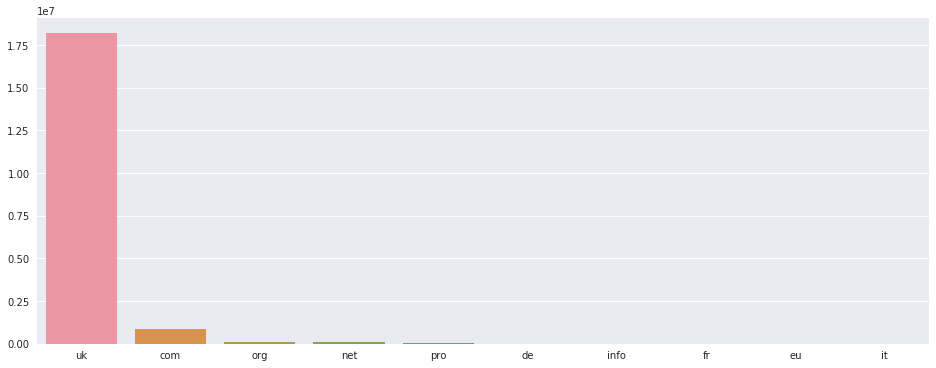

In [16]:
for tld, count in tlds.items():
    if ":" in tld:
        val = tlds.pop(tld)
        tlds[tld.split(":")[0]] += val

tld_labels = list(tlds.keys())
tld_total = sum(list(tlds.values()))
tld_fractions = [float(value)/float(tld_total) for value in tlds.values()]
tld_explode = [1 for l in tld_labels]

tlds_sorted = OrderedDict(sorted(tlds.items(), key=lambda x: x[1], reverse=True))

#plt.axis("equal")
#plt.pie(tld_fractions, labels=tld_labels, shadow=False, explode=tld_explode, autopct="%1.1f%%")

fig = plt.figure(figsize=(16,6))

# Plot up to 15
tldc = 10
if(len(tlds_sorted) < tldc):
    tldc = len(tlds_sorted)

seaborn.set_style("darkgrid")
seaborn.barplot(range(tldc), tlds_sorted.values()[:tldc])

plt.xticks(range(tldc), tlds_sorted.keys()[:tldc])
plt.show()


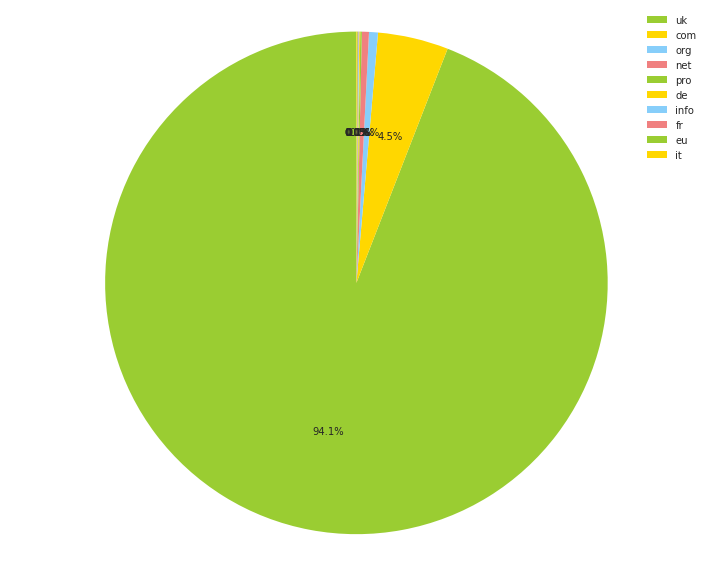

In [17]:
fig = plt.figure(figsize=(10,8))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
fewer_values = tlds_sorted.values()[0:tldc]
fewer_keys = tlds_sorted.keys()[0:tldc]
plt.pie(fewer_values, colors=colors, startangle=90, autopct='%1.1f%%')
plt.legend(fewer_keys, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

The above shows that things are very heavily skewed to `.uk` and `.com`. We can switch to a logarithmic scale to make things a bit clearer:

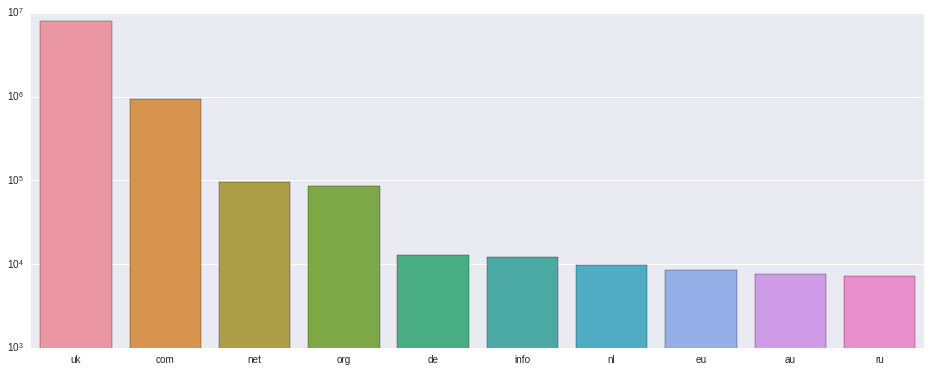

In [4]:
fig = plt.figure(figsize=(16,6))

seaborn.barplot(range(tldc), tlds_sorted.values()[:tldc])

plt.xticks(range(tldc), tlds_sorted.keys()[:tldc])
plt.yscale('log')
plt.show()


## Type of second level domain – so what % .co.uk, .org.uk , .ac.uk etc

OrderedDict([(u'co', 17070262), (u'org', 451205), (u'me', 69791), (u'ac', 34614), (u'sch', 17869), (u'gov', 11497), (u'nhs', 6022), (u'ltd', 4695), (u'net', 845), (u'plc', 165), (u'mod', 87), (u'parliament', 70), (u'nic', 65)])


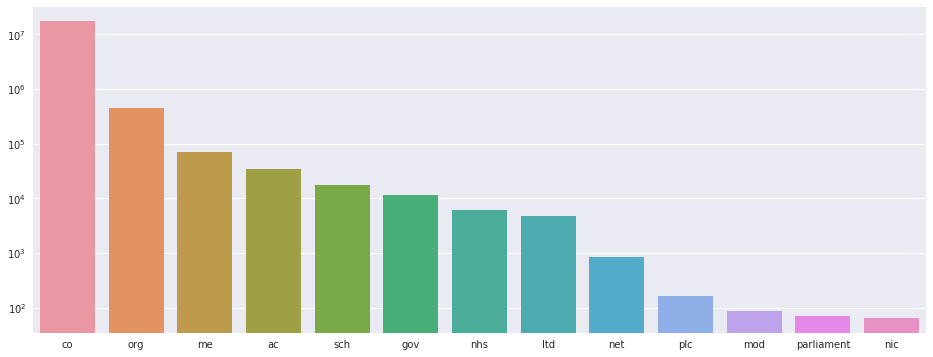

In [18]:
slds_sorted = OrderedDict(sorted(slds.items(), key=lambda x: x[1], reverse=True))

print(slds_sorted)

fig = plt.figure(figsize=(16,6))

seaborn.barplot(range(len(slds_sorted)), slds_sorted.values())

plt.xticks(range(len(slds_sorted)), slds_sorted.keys())
plt.yscale('log')
plt.show()


## Geolocation

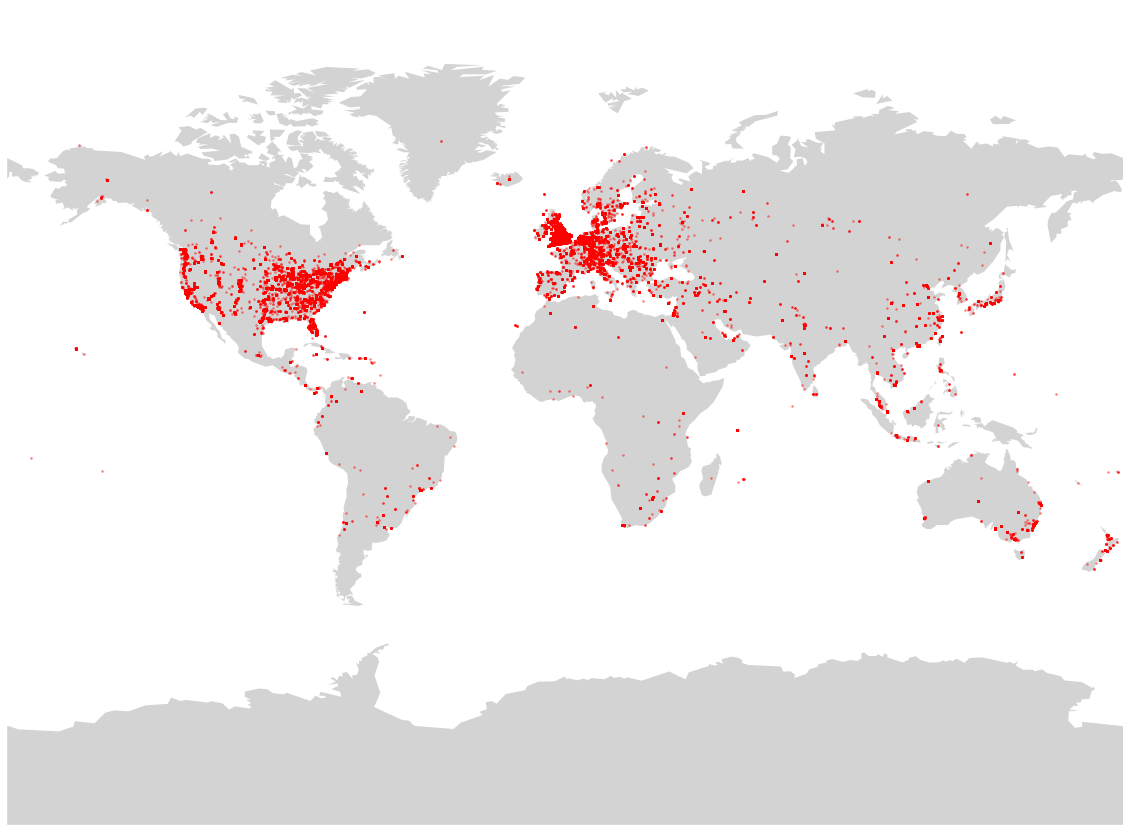

In [19]:
lat_y = [lat for lat, lon in lat_lon if lat is not None]
lon_x = [lon for lat, lon in lat_lon if lon is not None]

# Reset the plot colours for the map plots:
seaborn.set(rc={'axes.facecolor':'none', 'figure.facecolor':'none'})

fig = plt.figure(figsize=(20,16))

m = Basemap(projection='mill',lon_0=0)
#m = Basemap(llcrnrlon=-8.0,llcrnrlat=54.5,urcrnrlon=1.5,urcrnrlat=59.5,lat_ts=20,
#            resolution='h',projection='merc',lon_0=-4.36,lat_0=54.5)

#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
m.fillcontinents(color='lightgrey')
#m.drawmapboundary(fill_color='white') # fill to edge
#m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0]) # draw parallels
#m.drawmeridians(np.arange(0.,420.,60.),labels=[0,0,0,1]) # draw meridians

x1,y1=m(lon_x,lat_y)
#m.scatter(x1,y1,s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
m.plot(x1,y1, 'r.', markersize=5, alpha=0.5)


plt.savefig('2017-ldwa-map.png', bbox_inches='tight', dpi=150)
plt.savefig('2017-ldwa-map.pdf', bbox_inches='tight')

plt.show()

The above graph can be downloaded in [PNG](./2017-ldwa-map.png) or [PDF](./2017-ldwa-map.pdf) formats. 

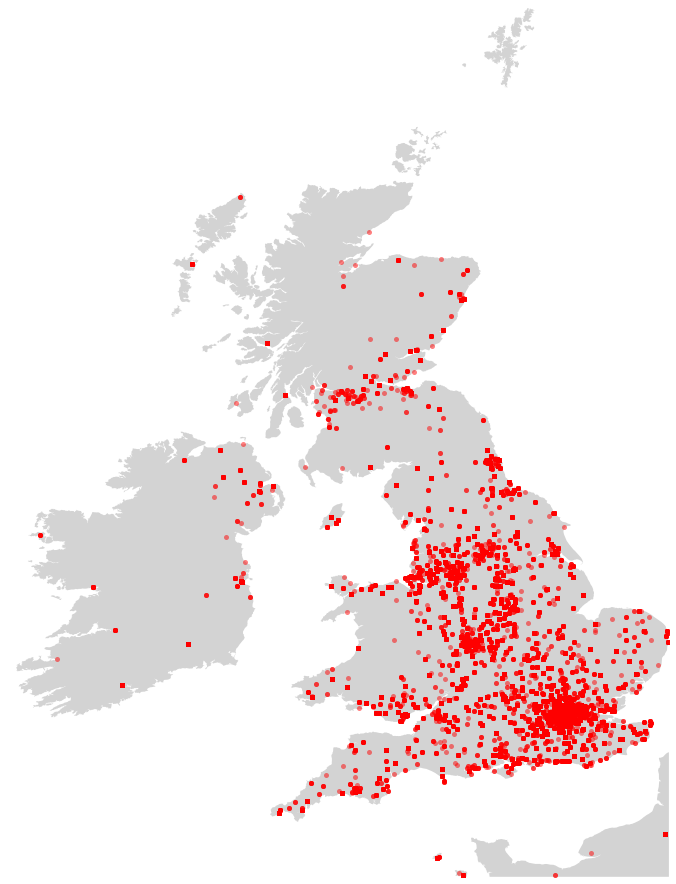

In [20]:
# Set up a UK bounding box:
bbox = {
  'lon': -5.23636,
  'lat': 53.866772,
  'll_lon': -10.65073,
  'll_lat': 49.16209,
  'ur_lon': 1.76334,
  'ur_lat': 60.860699
}

# Reset the plot colours for the map plots:
seaborn.set(rc={'axes.facecolor':'none', 'figure.facecolor':'none'})

fig = plt.figure(figsize=(20,16))

m = Basemap(
  projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
  llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
  urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'], resolution='h')

#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
m.fillcontinents(color='lightgrey')

x1,y1=m(lon_x,lat_y)
#m.scatter(x1,y1,s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
m.plot(x1,y1, 'r.', markersize=10, alpha=0.5)

plt.savefig('2017-ldwa-uk-map.png', bbox_inches='tight', dpi=150)
plt.savefig('2017-ldwa-uk-map.pdf', bbox_inches='tight')

plt.show()

The above graph can be downloaded in [PNG](./2017-ldwa-uk-map.png) or [PDF](./2017-ldwa-uk-map.pdf) formats. 

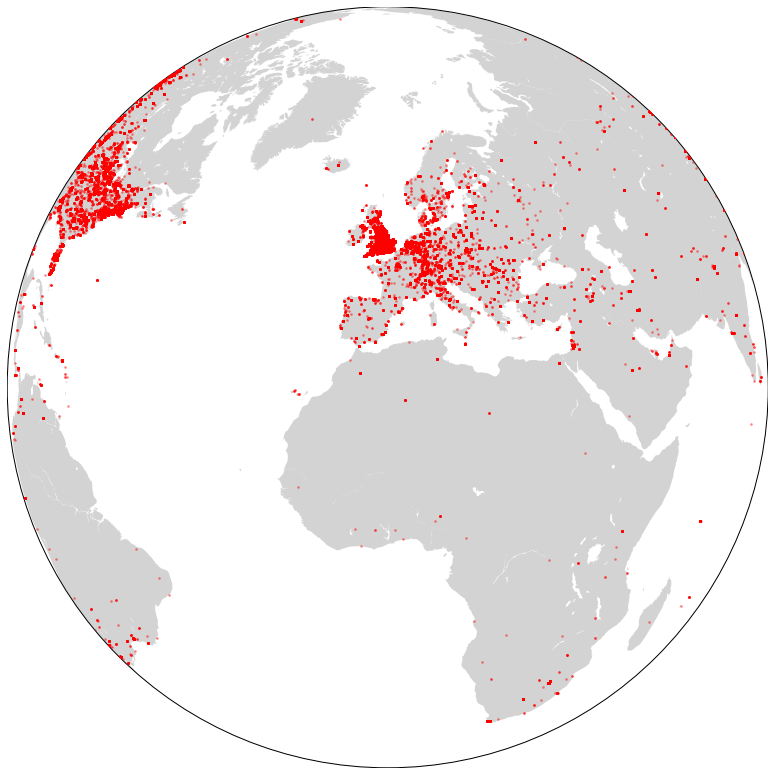

In [21]:
# Reset the plot colours for the map plots:
seaborn.set(rc={'axes.facecolor':'none', 'figure.facecolor':'none'})

fig = plt.figure(figsize=(14,14))

# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
map = Basemap(projection='ortho', lat_0=30, lon_0=0,
              resolution='l', area_thresh=1000.0)
 
#map.drawcoastlines(color='gray', linewidth=0.25)
#map.drawcountries(linewidth=0.25)
map.fillcontinents(color='lightgrey',lake_color='white')
# draw the edge of the map projection region (the projection limb)
#map.drawmapboundary(fill_color='aqua')

x,y = map(lon_x,lat_y)
map.plot(x, y, 'r.', markersize=5, alpha=0.5)

plt.savefig('2017-ldwa-globe-map.png', bbox_inches='tight', dpi=150)
plt.savefig('2017-ldwa-globe-map.pdf', bbox_inches='tight')

plt.show()

The above graph can be downloaded in [PNG](./2017-ldwa-globe-map.png) or [PDF](./2017-ldwa-globe-map.pdf) formats. 

## Largest sites in terms of no. of pages.

In [22]:
hosts_by_size = sorted(host_sizes.items(), key=lambda x:x[1])[-20:]
hosts_by_size.reverse()
print "\n".join([host for (host, size) in hosts_by_size])

gravatar.com
scotlandsplaces.org.uk
compare-the-price.co.uk
tumblr.com
carpforum.co.uk
gpwebsolutions-host.co.uk
guardian.co.uk
marklesley.info
thumbs2.ebaystatic.com
thumbs1.ebaystatic.com
thumbs3.ebaystatic.com
thumbs4.ebaystatic.com
images.productserve.com
m.zoopla.co.uk
reference.medscape.com
buttonnose.co.uk
data.ordnancesurvey.co.uk
bruford.ac.uk
media2.jupix.co.uk
compassionindying.org.uk


It's not clear how meaningful the above list is. Those sites with many resources may just be link farms or other search-engine spamming attempts.